# IMPORTS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import re
import os
from matplotlib.patches import ConnectionPatch
from pprint import pprint
from sklearn.metrics import average_precision_score
from random import sample

In [2]:
cv2.__version__

'3.4.2'

In [3]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'

# GET FOLDER + IMAGE + TRANSFORMATION NAMES

In [4]:
folders = glob.glob(project_root + '/hpatches-sequences-release/*')

In [5]:
folders[:10]

['/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_fest',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_chestnuts',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_nijmegen',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_calder',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_underground',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_talent',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_crownday',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_there',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_duda',
 '/home/davidboja/PycharmProje

In [6]:
len(folders)

116

In [7]:
image_names = glob.glob(project_root + '/hpatches-sequences-release/v_london/*.ppm')
image_names = [im.split('/')[-1] for im in image_names]
image_names = sorted(image_names)

In [8]:
image_names

['1.ppm', '2.ppm', '3.ppm', '4.ppm', '5.ppm', '6.ppm']

In [9]:
transformation_names = glob.glob(project_root + '/hpatches-sequences-release/v_london/H*')
transformation_names = [tr.split('/')[-1] for tr in transformation_names]
transformation_names = sorted(transformation_names)

In [10]:
transformation_names

['H_1_2', 'H_1_3', 'H_1_4', 'H_1_5', 'H_1_6']

Potential detector names:
    1. sift
    2. surf
    3. ORB
    
Potential descriptor names:
    1. sift
    2. surf
    3. ORB

In [248]:
all_detectors = {'sift':cv2.xfeatures2d.SIFT_create,
                 'surf':cv2.xfeatures2d.SURF_create,
                 'ORB':cv2.ORB_create,
                 'fast':cv2.FastFeatureDetector_create,
                 'brisk':cv2.BRISK_create}

all_descriptors = {'sift':cv2.xfeatures2d.SIFT_create,
                   'surf':cv2.xfeatures2d.SURF_create,
                   'ORB':cv2.ORB_create,
                   'brisk':cv2.BRISK_create}

# CURRENTLY COMPILED KP AND DES ON DISK

In [249]:
if 'kp.npz' in os.listdir(folders[0]):
    file = np.load(folders[0] + '/kp.npz')
    print(file.files)

['sift', 'fast']


In [250]:
if 'des.npz' in os.listdir(folders[0]):
    file = np.load(folders[0] + '/des.npz')
    print(file.files)

['sift_sift', 'fast_sift']


# TESTING

In [229]:
img = cv2.imread(folders[0] + '/1.ppm')

In [234]:
brisk = cv2.BRISK_create()

In [235]:
kp = brisk.detect(img, None)

In [ ]:
freak = cv2.xfeatures2d.FREAK_create()
kp , des = freak.compute(img,kp)

In [236]:
len(kp)

9912

In [ ]:
kp[0]

In [237]:
a = kp[0]

In [238]:
a.pt

(740.0669555664062, 19.43396759033203)

In [245]:
kp, des = brisk.compute(img, kp)

In [247]:
des.shape

(9912, 64)

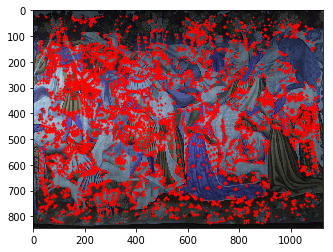

In [241]:
#img2 = cv2.drawKeypoints(img,kp,color=(0,255,0), flags=0)
plt.imshow(img)
plt.scatter([a.pt[0] for a in kp], [a.pt[1] for a in kp], s=0.9,c='red')
plt.show()

# LOAD IMAGES + FIND KP/DES + SAVE npy OF KP/DES

In [182]:
# #code for deleting all des.npz and kp.npz in all folders
# for folder in folders:
#     desss = glob.glob(folder + '/des*')
#     kpppp = glob.glob(folder + '/kp*')
#     for d in desss:
#         os.remove(d)
#     for k in kpppp:
#         os.remove(k)

In [251]:
detector_name = 'brisk'
descriptor_name = 'brisk'

In [252]:
sequence_images = {}
# transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    print('Working on folder {}'.format(folder_name))
    
    sequence_images[folder_name] = glob.glob(folder + '/*.ppm')
    #transformations[folder_name] = glob.glob(folder + '/H*')
    
    sequence_images[folder_name] = sorted(sequence_images[folder_name])
    #transformations[folder_name] = sorted(transformations[folder_name])

    sequence_images[folder_name] = [cv2.imread(im) for im in sequence_images[folder_name]]
    #transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]
    
    # find keypoints    
    images_ = [ cv2.cvtColor(im ,cv2.COLOR_RGB2GRAY) for im in sequence_images[folder_name]]
    
    
    detector = [ all_detectors[detector_name]() for im in sequence_images[folder_name]]
    descriptor = [ all_descriptors[descriptor_name]() for im in sequence_images[folder_name]]        
    
    kp = []
    des = []
    
    for id1, algorithm in enumerate(zip(detector,descriptor)):
        kp_ = algorithm[0].detect(images_[id1],None)
        
        kp_, des_ = algorithm[1].compute(images_[id1], kp_)
        
        #kp, des = det.detectAndCompute(images_[id1],None)
        
        # TODO: dodat da se proizvoljno spreme svi atributi koji postoje i da se 
        # negdje spremi sta sve posotji za taj kp
        kp_np = np.array([(k.pt[0], k.pt[1], k.angle, k.size, k.response) for k in kp_])
        
        kp.append(kp_np)
        des.append(des_)
        
#         np.save(folder + '/kp_' + algorithm_name + '_' + str(id1), kp_np) 
#         np.save(folder + '/des_' + algorithm_name + '_' + str(id1), des)
    if 'kp.npz' in os.listdir(folder):
        file = np.load(folder + '/kp.npz')
        elements = dict(file)
        elements[detector_name] = kp
        np.savez(folder + '/kp.npz', **elements)
        
    else:
        np.savez(folder + '/kp.npz', **{detector_name:kp})
        
    if 'des.npz' in os.listdir(folder):
        file = np.load(folder + '/des.npz')
        elements = dict(file)
        elements[detector_name + '_' + descriptor_name] = des
        np.savez(folder + '/des.npz', **elements)
        
    else:
        nm = detector_name + '_' + descriptor_name
        np.savez(folder + '/des.npz', **{nm:des})
        
#     np.savez(folder + '/kp_' + detector_name +  '.npz', *kp)
#     np.savez(folder + '/des_' + descriptor_name +  '.npz', *des)

Working on folder v_fest
Working on folder i_chestnuts
Working on folder i_nijmegen
Working on folder v_calder
Working on folder v_underground
Working on folder v_talent
Working on folder i_crownday
Working on folder v_there
Working on folder i_duda
Working on folder v_posters
Working on folder v_yuri
Working on folder i_objects
Working on folder i_nuts
Working on folder v_blueprint
Working on folder i_pencils
Working on folder i_fruits
Working on folder i_porta
Working on folder v_london
Working on folder v_beyus
Working on folder v_weapons
Working on folder v_graffiti
Working on folder v_azzola
Working on folder v_woman
Working on folder i_leuven
Working on folder v_vitro
Working on folder i_miniature
Working on folder v_bricks
Working on folder v_gardens
Working on folder i_londonbridge
Working on folder v_dirtywall
Working on folder i_dc
Working on folder v_wormhole
Working on folder i_contruction
Working on folder i_boutique
Working on folder i_books
Working on folder v_charing
Wo

# LOAD KP/DES npy AND REMOVE UNCOMMON POINTS

In [253]:
detector_name = 'brisk'
descriptor_name = 'brisk'

In [254]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [255]:
transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    transformations[folder_name] = glob.glob(folder + '/H*')
    transformations[folder_name] = sorted(transformations[folder_name])
    transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

In [256]:
# # VERZIJA KODA KOJI BRISE UNCOMMON POINTS SA REF SLIKE I SA SEQUENCE SLIKA --> ODLUCILI DA TO NE TREBA
# for folder in folders:
#     folder_name = folder.split('/')[-1]
#     print('#########################################')
#     print('Working on folder {}'.format(folder_name))
        
# #     kp_names = glob.glob(folder + '/kp_' + algorithm_name + '*')
# #     kp_names = sorted(kp_names)
# #     kp = [np.load(k) for k in kp_names]
    
# #     des_names = glob.glob(folder + '/des_' + algorithm_name + '*')
# #     des_names = sorted(des_names)
# #     des = [np.load(d) for d in des_names]

#     kp_file = np.load(folder + '/kp.npz')
#     kp = kp_file[detector_name]
#     kp = list(kp)
    
#     des_file = np.load(folder + '/des.npz')
#     nm = detector_name + '_' + descriptor_name
#     des = des_file[nm]
#     des = list(des)
    
#     indexes_to_remove = []
    
#     # iterate over sequence images, find keypoints, remove keypoints that do not appear on all the images
#     for id1, kp_ in enumerate(kp):
        
#         # remove keypoints from ref image that do not appear on sequence images
#         if id1 == 0:
#             print('Removing kp from image 1.ppm')
            
#             remove = set()
            
#             for id2, tr in enumerate(transformations[folder_name]):
#                 points = np.c_[ kp_[:,[0,1]] , np.ones(kp_.shape[0])]
#                 imaged_points = np.dot(tr, points.T)
#                 imaged_points_normal = imaged_points/imaged_points[2,:]
                
#                 image_size = cv2.imread(folder + '/' + str(id2+2) + '.ppm' )
#                 image_size = image_size.shape
# #                 print(image_size)
                
#                 x_indexes_out_of_bounds = np.where((imaged_points_normal[0,:] < 0) |
#                                                    (image_size[1] < imaged_points_normal[0,:]))[0]
                
# #                 print(x_indexes_out_of_bounds)
                
#                 y_indexes_out_of_bounds = np.where((imaged_points_normal[1,:] < 0) |
#                                                    (image_size[0] < imaged_points_normal[1,:]))[0]
                
# #                 print(y_indexes_out_of_bounds)
                
#                 remove = remove.union(x_indexes_out_of_bounds)
#                 remove = remove.union(y_indexes_out_of_bounds)
                
#             indexes_to_remove.append(list(remove))
        
#         # remove keypoints from ref image that do not appear on sequence images
#         else:
#             print('Removing kp from image {}'.format(image_names[id1]))
            
#             remove = set()
#             image_size = cv2.imread(folder + '/1.ppm' ).shape
# #             print(image_size)
            
#             # image every keypoint on sequence image back on ref image and check if 
#             # it is contained in the ref image
            
#             tr = transformations[folder_name][id1-1]
            
#             points = np.c_[ kp_[:,[0,1]] , np.ones(kp_.shape[0])]
#             imaged_points = np.dot(np.linalg.inv(tr), points.T)
#             imaged_points_normal = imaged_points/imaged_points[2,:]
            
#             x_indexes_out_of_bounds = np.where((imaged_points_normal[0,:] < 0) |
#                                                    (image_size[1] < imaged_points_normal[0,:]))[0]
            
#             y_indexes_out_of_bounds = np.where((imaged_points_normal[1,:] < 0) |
#                                                    (image_size[0] < imaged_points_normal[1,:]))[0]
            
#             remove = remove.union(x_indexes_out_of_bounds)
#             remove = remove.union(y_indexes_out_of_bounds)
            
#             indexes_to_remove.append(list(remove))
            
            
#     for id2,ind in enumerate(indexes_to_remove):
#         print('Removed {} keypoints from image {}'.format(len(ind), image_names[id2]))
#         print('old size: {}'.format(kp[id2].shape))

#         kp[id2] = np.delete(kp[id2], ind, 0)
#         #np.save(kp_names[id2], kp[id2])
#         print('new size: {}'.format(kp[id2].shape))

#         des[id2] = np.delete(des[id2], ind, 0)
#         #np.save(des_names[id2], des[id2])
        
#     elements = dict(kp_file)
#     elements[detector_name] = kp
#     np.savez(folder + '/kp.npz', **elements)
    
#     elements = dict(des_file)
#     elements[nm] = des
#     np.savez(folder + '/des.npz', **elements)

In [257]:
# VERZIJA KODA KOJA BRISE KEYPOINTOVE SAMO SA REF SLIKE 
for folder in folders:
    folder_name = folder.split('/')[-1]
    print('#########################################')
    print('Working on folder {}'.format(folder_name))

    kp_file = np.load(folder + '/kp.npz')
    kp = kp_file[detector_name]
    kp = list(kp)
    
    des_file = np.load(folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des = des_file[nm]
    des = list(des)
    
    indexes_to_remove = []
        
    # remove keypoints from ref image that do not appear on sequence images

    remove = set()
    kp_ = kp[0].copy()

    for id2, tr in enumerate(transformations[folder_name]):
        points = np.c_[ kp_[:,[0,1]] , np.ones(kp_.shape[0])]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]

        image_size = cv2.imread(folder + '/' + str(id2+2) + '.ppm' )
        image_size = image_size.shape

        x_indexes_out_of_bounds = np.where((imaged_points_normal[0,:] < 0) |
                                           (image_size[1] < imaged_points_normal[0,:]))[0]


        y_indexes_out_of_bounds = np.where((imaged_points_normal[1,:] < 0) |
                                           (image_size[0] < imaged_points_normal[1,:]))[0]


        remove = remove.union(x_indexes_out_of_bounds)
        remove = remove.union(y_indexes_out_of_bounds)

    indexes_to_remove = list(remove)
    
    print('Removed {} keypoints from image {}/1.ppm'.format(len(indexes_to_remove),folder_name))
    print('old size: {}'.format(kp[0].shape))
    kp[0] = np.delete(kp[0], indexes_to_remove, 0)
    print('new size: {}'.format(kp[0].shape))
    
    des[0] = np.delete(des[0], indexes_to_remove, 0)
            
        
    elements = dict(kp_file)
    elements[detector_name] = kp
    np.savez(folder + '/kp.npz', **elements)
    
    elements = dict(des_file)
    elements[nm] = des
    np.savez(folder + '/des.npz', **elements)

#########################################
Working on folder v_fest
Removed 4126 keypoints from image v_fest/1.ppm
old size: (9669, 5)
new size: (5543, 5)
#########################################
Working on folder i_chestnuts
Removed 0 keypoints from image i_chestnuts/1.ppm
old size: (3326, 5)
new size: (3326, 5)
#########################################
Working on folder i_nijmegen
Removed 0 keypoints from image i_nijmegen/1.ppm
old size: (13502, 5)
new size: (13502, 5)
#########################################
Working on folder v_calder
Removed 73 keypoints from image v_calder/1.ppm
old size: (3335, 5)
new size: (3262, 5)
#########################################
Working on folder v_underground
Removed 1504 keypoints from image v_underground/1.ppm
old size: (5075, 5)
new size: (3571, 5)
#########################################
Working on folder v_talent
Removed 108 keypoints from image v_talent/1.ppm
old size: (8856, 5)
new size: (8748, 5)
#########################################
W

#########################################
Working on folder i_toy
Removed 0 keypoints from image i_toy/1.ppm
old size: (641, 5)
new size: (641, 5)
#########################################
Working on folder v_apprentices
Removed 1238 keypoints from image v_apprentices/1.ppm
old size: (23398, 5)
new size: (22160, 5)
#########################################
Working on folder v_home
Removed 2452 keypoints from image v_home/1.ppm
old size: (7661, 5)
new size: (5209, 5)
#########################################
Working on folder i_lionday
Removed 0 keypoints from image i_lionday/1.ppm
old size: (1287, 5)
new size: (1287, 5)
#########################################
Working on folder v_bark
Removed 95 keypoints from image v_bark/1.ppm
old size: (2195, 5)
new size: (2100, 5)
#########################################
Working on folder v_samples
Removed 240 keypoints from image v_samples/1.ppm
old size: (7492, 5)
new size: (7252, 5)
#########################################
Working on folder v

Removed 392 keypoints from image v_courses/1.ppm
old size: (6397, 5)
new size: (6005, 5)
#########################################
Working on folder v_colors
Removed 85 keypoints from image v_colors/1.ppm
old size: (646, 5)
new size: (561, 5)
#########################################
Working on folder i_ktirio
Removed 0 keypoints from image i_ktirio/1.ppm
old size: (1785, 5)
new size: (1785, 5)
#########################################
Working on folder v_wounded
Removed 4282 keypoints from image v_wounded/1.ppm
old size: (7804, 5)
new size: (3522, 5)
#########################################
Working on folder v_tabletop
Removed 5194 keypoints from image v_tabletop/1.ppm
old size: (16558, 5)
new size: (11364, 5)
#########################################
Working on folder v_birdwoman
Removed 536 keypoints from image v_birdwoman/1.ppm
old size: (10761, 5)
new size: (10225, 5)
#########################################
Working on folder v_yard
Removed 4307 keypoints from image v_yard/1.ppm

# VISUALIZE SEQUENCE IMAGES FOR FOLDER

In [66]:
# folder_name = 'v_london'

# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
# for i, axx in enumerate(ax.ravel()):
#     axx.imshow(sequence_images[folder_name][i])
#     axx.set_title('{}'.format(image_names[i]))
# plt.show()

# VISUALIZE KEYPOINTS FOR GIVEN FOLDER AND ALGORITHM

In [204]:
folder = 'v_weapons'
detector_name = 'brisk'

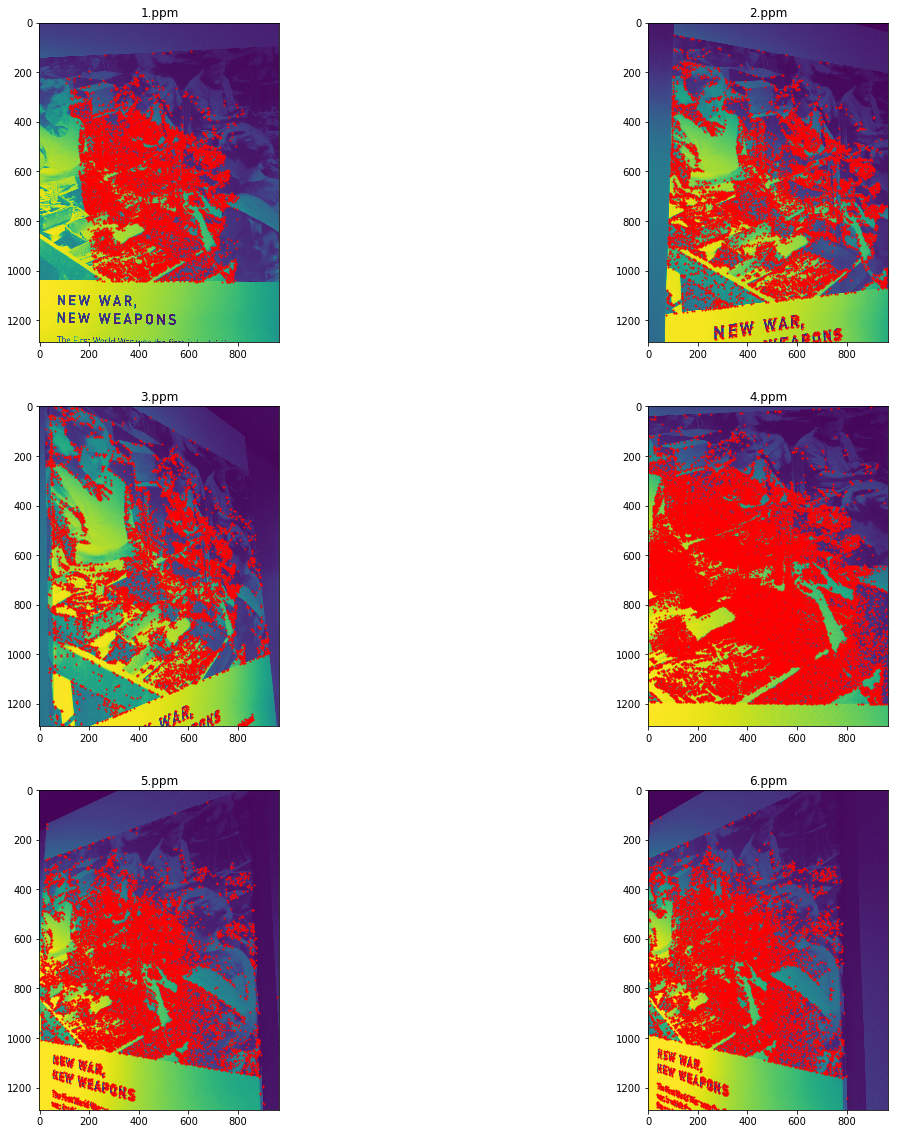

In [205]:
sequence_images = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/*.ppm')
sequence_images = sorted(sequence_images)
sequence_images = [cv2.imread(im) for im in sequence_images]

# kp_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/kp_' + algorithm_name + '*')
# kp_names = sorted(kp_names)
# kp = [np.load(k) for k in kp_names]

kp = np.load(project_root + '/hpatches-sequences-release/' + folder + '/kp.npz')
kp = kp[detector_name]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for id1, axx in enumerate(ax.ravel()):
    
    gray = cv2.cvtColor(sequence_images[id1] ,cv2.COLOR_RGB2GRAY)
#     gray_with_kp = cv2.drawKeypoints(gray, 
#                                      kp[id1], 
#                                      cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    
#     axx.imshow(gray_with_kp)

    axx.imshow(gray)
    axx.scatter(kp[id1][:,0],kp[id1][:,1], s=1, color='red')
    axx.set_title('{}'.format(image_names[id1]))
plt.show()

# DRAW TOP TEN MATCHES FOR GIVEN FOLDER AND ALGORITHM

In [206]:
folder = 'v_london'
detector_name = 'brisk'
descriptor_name = 'brisk'

### LOAD  IMG/KP/DES

In [207]:
sequence_images = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/*.ppm')
sequence_images = sorted(sequence_images)
sequence_images = [cv2.imread(im) for im in sequence_images]

# kp_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/kp_' + detector_name + '*')
# kp_names = sorted(kp_names)
# kp = [np.load(k) for k in kp_names]

# des_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/des_' + descriptor_name + '*')
# des_names = sorted(des_names)
# des = [np.load(d) for d in des_names]

kp = np.load(project_root + '/hpatches-sequences-release/' + folder + '/kp.npz')
kp = kp[detector_name]

des = np.load(project_root + '/hpatches-sequences-release/' + folder + '/des.npz')
nm = detector_name + '_' + descriptor_name
des = des[nm]

In [208]:
print(len(sequence_images))
print(len(kp))
print(len(des))

6
6
6


### COMPUTE MATCHES

In [209]:
matches_with_ref = []

In [210]:
for dess in des[1:]:
    bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
    matches = bf.match(des[0], dess)
    matches_with_ref.append(sorted(matches, key = lambda x:x.distance))

In [211]:
len(matches_with_ref)

5

### VISUALIZE TOP TEN MATCHES FOR SEQUENCE

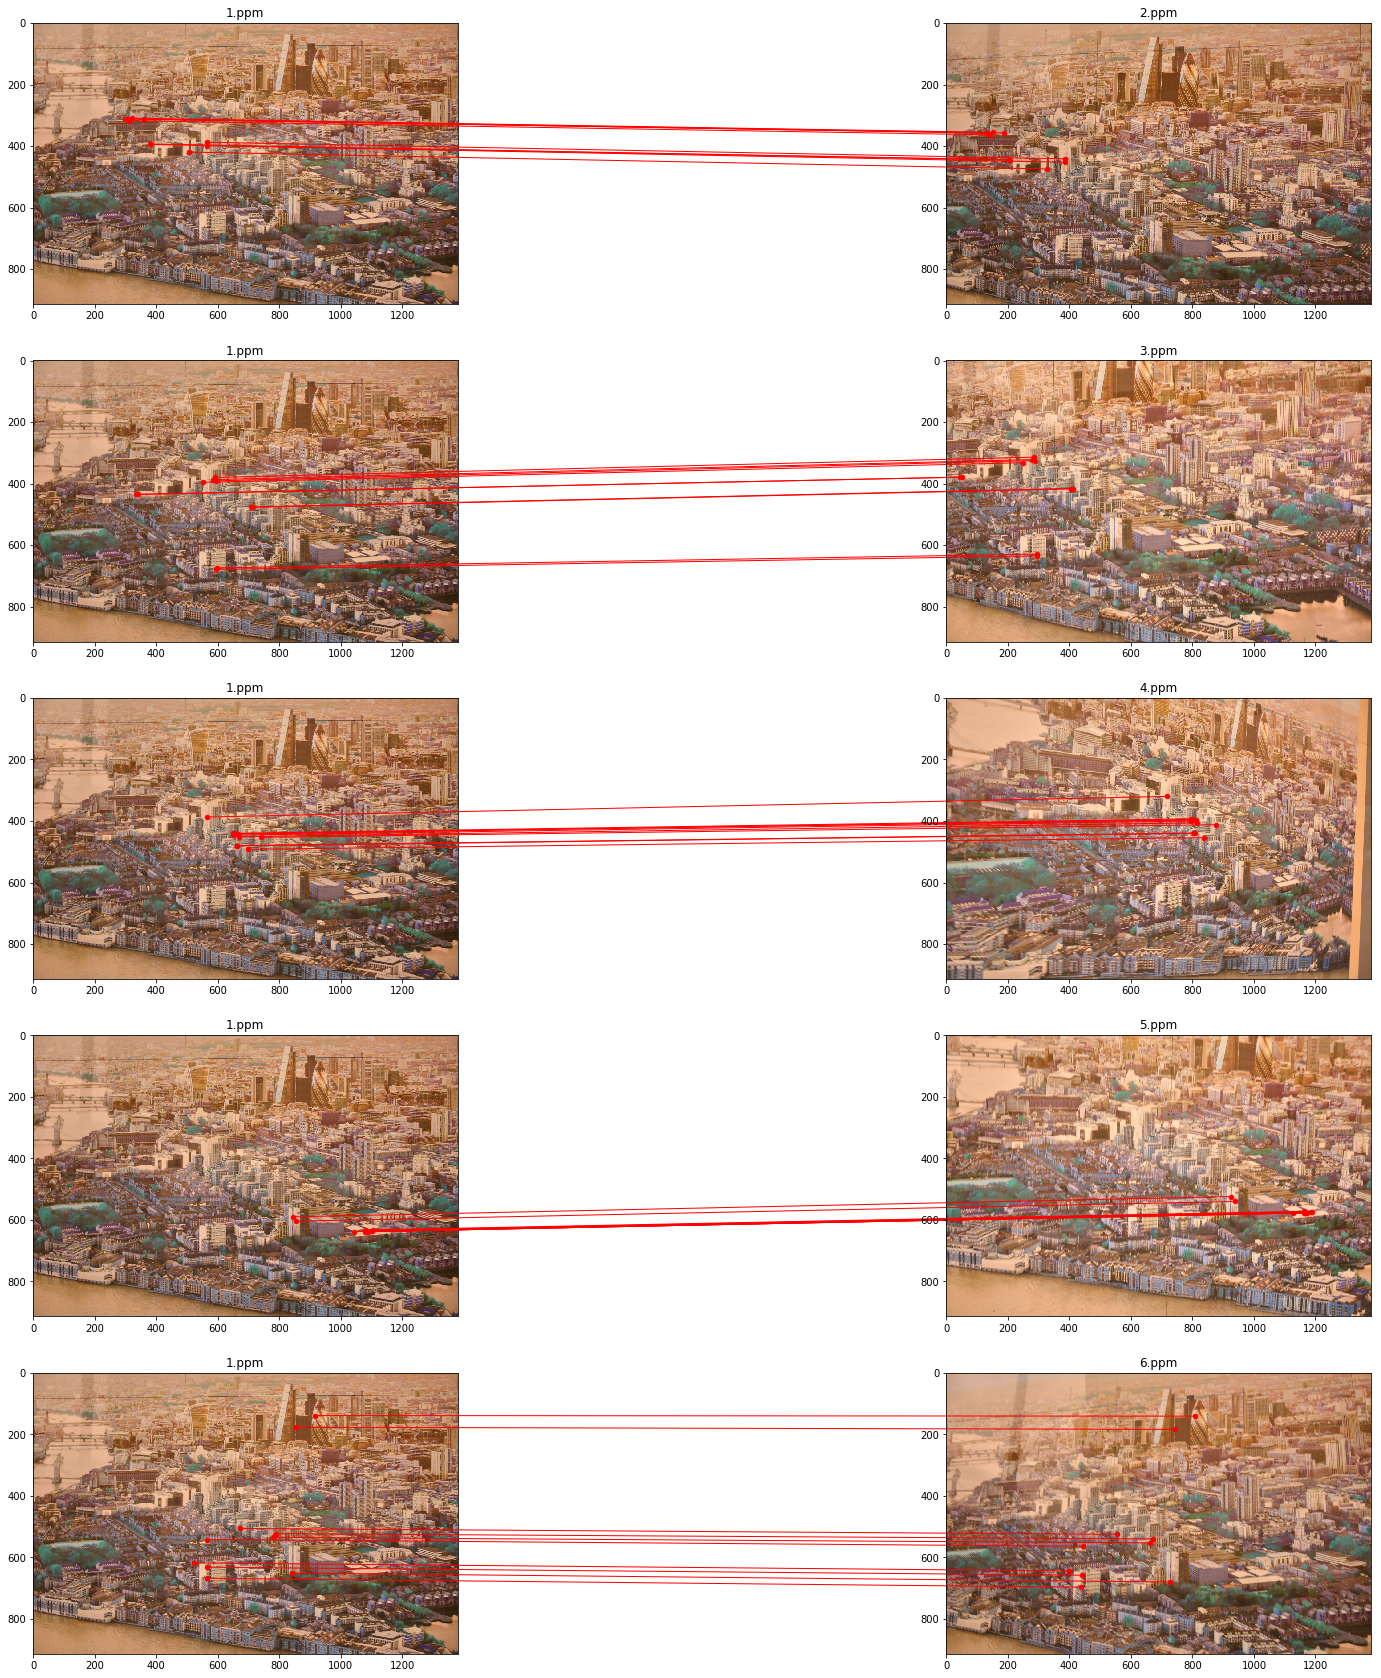

In [212]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30,30))
for i, axx in enumerate(ax.ravel()):
    if (i % 2) == 1:
        continue
        
    points_on_first_img = []
    points_on_second_img = []
    
    axx.imshow(sequence_images[0])
    axx.set_title('{}'.format(image_names[0]))
    ax.ravel()[i+1].imshow(sequence_images[int(i/2)+1])
    ax.ravel()[i+1].set_title('{}'.format(image_names[int(i/2)+1]))
    
    for m in matches_with_ref[int(i/2)][:10]:
        points_on_first_img.append(kp[0][m.queryIdx,[0,1]])
        points_on_second_img.append(kp[int(i/2)+1][m.trainIdx,[0,1]])
        
    axx.scatter([i[0] for i in points_on_first_img],
                [i[1] for i in points_on_first_img],
                s=20, 
                c='red')
    
    ax.ravel()[i+1].scatter([i[0] for i in points_on_second_img],
                            [i[1] for i in points_on_second_img],
                            s=20, 
                            c='red')
    
    for j in range(len(points_on_first_img)):
        con = ConnectionPatch(xyA=(points_on_second_img[j][0],points_on_second_img[j][1]), 
                              xyB=(points_on_first_img[j][0],points_on_first_img[j][1]),
                              coordsA="data", coordsB="data",
                              axesA=ax.ravel()[i+1], axesB=axx, color="red")
        
        ax.ravel()[i+1].add_artist(con)
    

plt.show()

# EVALUATION

# TASK 1: PATCH VERIFICATION

In [213]:
n = 50

In [214]:
detector_name = 'brisk'
descriptor_name = 'brisk'

In [215]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [216]:
transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    transformations[folder_name] = glob.glob(folder + '/H*')
    transformations[folder_name] = sorted(transformations[folder_name])
    transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

In [217]:
# c = np.array([[1,2,3],[4,5,6],[7,8,9],[11,12,13]])
# a = np.array([[1,2,3],[4,5,6],[7,8,9]])
# b = np.array([[11,5,4],[5,8,9],[1,3,7]])

In [218]:
y = []
s = []

for id1, folder in enumerate(folders):
    
    folder_name = folder.split('/')[-1]

    # get keypoints from sequence in folder
    kp = np.load(folder + '/kp.npz')
    kp = kp[detector_name]
    kp = list(kp)
    print([kp_.shape for kp_ in kp])
    
    # get descriptors from sequence in folder
    des = np.load(folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des = des[nm]
    des = list(des)

    # get keypoints from next folder
    if id1 != (len(folders)-1):
        next_folder = folders[id1+1]
    else:
        next_folder = folders[0]
        
    print('Working on folder {} --> next_folder {}'.format(folder_name,next_folder.split('/')[-1]))

    kp_next = np.load(next_folder + '/kp.npz')
    kp_next = kp_next[detector_name]
    kp_next = list(kp_next)
    
    des_next = np.load(next_folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des_next = des_next[nm]
    des_next = list(des_next)
    
    # check if an image has no keypoints and skip that evaluating sequence  
    if 0 == kp[0].shape[0]:
        print('Folder {} has 0 keypoints for ref image'.format(folder))
        print('SKIPPING THIS FOLDER')
        continue
    
    # random keypoints from ref image
    nr_of_indexes = min(n,kp[0].shape[0])
    random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)
    # print(random_keypoint_indexes)
    
    # choose ref image
    x_kp = kp[0][random_keypoint_indexes,:]
    x_des = des[0][random_keypoint_indexes,:]
    
    
    for id1, dess in enumerate(des[1:]):
        
        #random_keypoint_indexes_crtano = sample(range(dess.shape[0]), n)
        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)#[random_keypoint_indexes_crtano,:])
        
        x_idx = [random_keypoint_indexes[m.queryIdx] for m in matches]
        x_crtano_idx = [m.trainIdx for m in matches]
        
        s += [m.distance for m in matches]
        
        # image every keypoint on ref image on 
        # ovdje su Hx spremljeni u stupce, 3xn matrica (treci redak su jedinice)
        tr = transformations[folder_name][id1]
        points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]
        
        # compute distance from Hx and x'
        dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
        distances = np.sqrt(np.sum((dist)**2,axis=0))
        
        # find if x' is the closest keypoint to Hx and assign y
        for i in range(imaged_points_normal.shape[1]):
            # dist_ is the distance from point Hx and every keypoint of image id1+1
            diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
            dist_ = np.sqrt(np.sum((diff)**2,axis=0))
            if (dist_ < distances[i]).any():
                y.append(-1)
            else:
                y.append(1)  
    
    for id2, dess in enumerate(des_next[1:]):
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)#[random_keypoint_indexes_crtano,:])
        
        s += [m.distance for m in matches]
        y += [-1 for m in matches]

[(11613, 5), (24854, 5), (25080, 5), (24797, 5), (25799, 5), (25742, 5)]
Working on folder v_fest --> next_folder i_chestnuts
[(4788, 5), (6528, 5), (6535, 5), (5989, 5), (4977, 5), (4361, 5)]
Working on folder i_chestnuts --> next_folder i_nijmegen
[(39027, 5), (32448, 5), (39481, 5), (17146, 5), (33876, 5), (32966, 5)]
Working on folder i_nijmegen --> next_folder v_calder
[(14260, 5), (11667, 5), (15124, 5), (8046, 5), (10051, 5), (7360, 5)]
Working on folder v_calder --> next_folder v_underground
[(4997, 5), (8446, 5), (5650, 5), (4015, 5), (2512, 5), (1849, 5)]
Working on folder v_underground --> next_folder v_talent
[(13910, 5), (16668, 5), (15865, 5), (20399, 5), (16527, 5), (17078, 5)]
Working on folder v_talent --> next_folder i_crownday
[(15887, 5), (15910, 5), (14436, 5), (13909, 5), (12068, 5), (14964, 5)]
Working on folder i_crownday --> next_folder v_there
[(13309, 5), (7626, 5), (8129, 5), (5946, 5), (5295, 5), (5706, 5)]
Working on folder v_there --> next_folder i_duda
[

Working on folder v_eastsouth --> next_folder i_nescafe
[(2896, 5), (3230, 5), (4019, 5), (3517, 5), (2747, 5), (4590, 5)]
Working on folder i_nescafe --> next_folder v_busstop
[(48685, 5), (62278, 5), (63123, 5), (66815, 5), (60826, 5), (63585, 5)]
Working on folder v_busstop --> next_folder i_indiana
[(20217, 5), (26936, 5), (31707, 5), (33576, 5), (34116, 5), (34634, 5)]
Working on folder i_indiana --> next_folder v_bees
[(10695, 5), (14720, 5), (12792, 5), (12803, 5), (7194, 5), (16903, 5)]
Working on folder v_bees --> next_folder i_brooklyn
[(24526, 5), (28246, 5), (20921, 5), (24094, 5), (22083, 5), (26456, 5)]
Working on folder i_brooklyn --> next_folder i_greentea
[(5616, 5), (4822, 5), (6878, 5), (6547, 5), (5334, 5), (4224, 5)]
Working on folder i_greentea --> next_folder v_coffeehouse
[(5650, 5), (14884, 5), (16498, 5), (9963, 5), (18634, 5), (13175, 5)]
Working on folder v_coffeehouse --> next_folder i_castle
[(12022, 5), (11457, 5), (8990, 5), (6554, 5), (5734, 5), (10092,

In [219]:
s[:10]

[217.86463928222656,
 140.5062255859375,
 157.86386108398438,
 356.92156982421875,
 133.08644104003906,
 181.0248565673828,
 158.3603515625,
 158.21188354492188,
 91.6515121459961,
 160.875732421875]

In [220]:
s2 = [-s_ for s_ in s]

In [221]:
y[:10]

[1, 1, 1, -1, 1, 1, 1, -1, 1, -1]

In [222]:
print(y.count(1))
print(y.count(-1))

11662
46338


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [223]:
n*10*len(folders) == len(y)

True

Potencijalnih matcheva je n * 5 * broj_foldera

In [224]:
n * 5 * len(folders)

29000

In [225]:
AP = average_precision_score(y,s2)
print(AP)

0.6984606609463924


In [226]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | fast | sift | 0.6984606609463924 | 50 | 11662 | 46338 | 29000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | sift | sift | 0.586862720350904 | 100 | 14914 | 101086 | 58000 |
| 2 | sift | sift | 0.593464318477201 | 100 | 15239 | 100761 | 58000 |
| 3 | sift | sift | 0.6065553783395058 | 100 | 15187 | 100813 | 58000 |
| 4 | sift | sift | 0.5908968401464723 | 100 | 15141 | 100859 | 58000 |
| 5 | sift | sift | 0.6003174809347416 | 100 | 15107 | 100893 | 58000 |
| 6 | surf | surf | 0.3899221777180763 | 100 | 13210 | 102790 | 58000 |
| 7 | ORB | ORB | 0.4301131784419977 | 50 | 3708 | 53212 | 29000 |
| 8 | fast | sift | 0.6984606609463924 | 50 | 11662 | 46338 | 29000 |


n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

| id | det | des | 5_mAP | n | mean 1 | mean -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | sift | sift | 0.5956193476497649 | 100 | 15117.6 | 100882.4 | 58000 |

In [50]:
# ranked_list = sorted(range(len(s)), key=lambda k: s[k])

# TASK 2: IMAGE MATCHING

In [413]:
n = 5

In [ ]:
y = []
s = []

for id1, folder in enumerate(folders):
    
    folder_name = folder.split('/')[-1]

    # get keypoints from sequence in folder
    kp = np.load(folder + '/kp.npz')
    kp = kp[detector_name]
    
    # get descriptors from sequence in folder
    des = np.load(folder + '/des.npz')
    des = des[descriptor_name]

    
    # random keypoints from ref image
    random_keypoint_indexes = [sample(range(kp_.shape[0]), n) for kp_ in kp]
    
    # cut down kp and des
    kp = [kp_[random_keypoint_indexes[id1],:] for id1, kp_ in enumerate(kp)]
    des = [des_[random_keypoint_indexes[id1],:] for id1, des_ in enumerate(des)]
    
    
    for id1, dess in enumerate(des[1:]):
        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(des[0], dess)
        
        x_idx = [ m.queryIdx for m in matches]
        x_crtano_idx = [ m.trainIdx for m in matches]
        
        s += [m.distance for m in matches]
        
        # OVDJE SI STAO
        
        # image every keypoint on ref image on 
        # ovdje su Hx spremljeni u stupce, 3xn matrica (treci redak su jedinice)
        tr = transformations[folder_name][id1]
        points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]
        
        # compute distance from Hx and x'
        dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
        distances = np.sqrt(np.sum((dist)**2,axis=0))
        
        # find if x' is the closest keypoint to Hx and assign y
        for i in range(imaged_points_normal.shape[1]):
            # dist_ is the distance from point Hx and every keypoint of image id1+1
            diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
            dist_ = np.sqrt(np.sum((diff)**2,axis=0))
            if (dist_ < distances[i]).any():
                y.append(-1)
            else:
                y.append(1)  
    
    for id2, dess in enumerate(des_next[1:]):
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)#[random_keypoint_indexes_crtano,:])
        
        s += [m.distance for m in matches]
        y += [-1 for m in matches]

In [414]:
random_keypoint_indexes = sample(range(len(keypoint_dict['1.ppm']['kp'])), n)

In [415]:
random_keypoint_indexes

[1853, 7884, 9478, 7537, 3725, 3707, 9943, 6780, 1362, 9]

In [416]:
x = list(np.array(keypoint_dict['1.ppm']['kp'])[random_keypoint_indexes])
x_desc = (keypoint_dict['1.ppm']['des'])[random_keypoint_indexes]

In [417]:
x

[<KeyPoint 0x7f60265a0840>,
 <KeyPoint 0x7f60264f2d20>,
 <KeyPoint 0x7f602650b3f0>,
 <KeyPoint 0x7f60264edf30>,
 <KeyPoint 0x7f60265397b0>,
 <KeyPoint 0x7f6026539390>,
 <KeyPoint 0x7f6026513600>,
 <KeyPoint 0x7f6026563de0>,
 <KeyPoint 0x7f602659a150>,
 <KeyPoint 0x7f6026587750>]

In [418]:
x_desc

array([[ 24.,  29.,  28., ...,  10.,   6.,   7.],
       [ 26.,  17.,   4., ...,  44.,  17.,   0.],
       [ 26.,  17.,   6., ...,   6.,  11.,   3.],
       ...,
       [116.,  84.,   4., ...,  30.,  10.,  14.],
       [ 37.,  65.,   3., ...,  10.,   6.,   2.],
       [  2.,   4.,   9., ...,   0.,   2.,  36.]], dtype=float32)

In [419]:
# NAMJESTAVANJE
fixed_keypoint_indexes = [0,1,2,3,4,5,6,7,8,9]

x = list(np.array(keypoint_dict['1.ppm']['kp'])[fixed_keypoint_indexes])
x_desc = (keypoint_dict['1.ppm']['des'])[fixed_keypoint_indexes]

In [420]:
x_crtano = []
x_crtano_names = []
x_crtano_desc = np.array([])

for id1,name in enumerate(image_names[1:]):
    random_keypoint_indexes = sample(range(len(keypoint_dict[name]['kp'])), n)
    
    x_crtano += list(np.array(keypoint_dict[name]['kp'])[random_keypoint_indexes])
    x_crtano_names += [name]*len(random_keypoint_indexes)
    if id1 == 0:
        x_crtano_desc = (keypoint_dict[name]['des'])[random_keypoint_indexes]
    else:
        x_crtano_desc = np.concatenate((x_crtano_desc, 
                                        (keypoint_dict[name]['des'])[random_keypoint_indexes] ),axis=0)

In [421]:
x_crtano[:5]

[<KeyPoint 0x7f60264e8900>,
 <KeyPoint 0x7f6020032f00>,
 <KeyPoint 0x7f60200a2480>,
 <KeyPoint 0x7f6020037270>,
 <KeyPoint 0x7f602008e3f0>]

In [422]:
x_crtano_names[:5]

['2.ppm', '2.ppm', '2.ppm', '2.ppm', '2.ppm']

In [423]:
x_crtano_desc

array([[ 41.,  18.,  13., ...,  16.,   0.,   2.],
       [ 65.,  37.,  22., ...,   5.,  10.,  80.],
       [ 58.,  20.,   5., ...,  22.,  37.,   0.],
       ...,
       [111., 129.,   1., ...,   3.,   7.,   3.],
       [  1.,   1.,  10., ...,  35.,  43.,  33.],
       [  2.,   0.,   0., ...,  39.,   1.,   1.]], dtype=float32)

In [431]:
# NAMJESTAVANJE
x_crtano[0] = keypoint_dict['2.ppm']['kp'][967]
x_crtano[1] = keypoint_dict['2.ppm']['kp'][9838]

x_crtano_desc[[0,1],:] = (keypoint_dict['2.ppm']['des'])[[967,9838]]

In [398]:
# a = []
# imp = np.dot(transformations_matrices[0] ,np.array(keypoint_dict['1.ppm']['kp'][0].pt+(1,)).reshape(3,1))
# imp_n = imp/imp[2,:]

In [404]:
# a = []
# imp = np.dot(transformations_matrices[0] ,np.array(keypoint_dict['1.ppm']['kp'][0].pt+(1,)).reshape(3,1))
# imp_n = imp/imp[2,:]
# for kp in keypoint_dict['2.ppm']['kp']:
#     a.append(np.linalg.norm(np.array(kp.pt)-imp_n[:2]))
# np.argmin(a)

In [434]:
s = []
y = []
x_points = [x_.pt + (1,) for x_ in x]

for i in range(5):
    
    print('{}-{}'.format(n*i,n*(i+1)))
    print('############')
    
    # match selected keypoints
    bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
    matches = bf.match(x_desc, x_crtano_desc[n*i:n*(i+1)])
    
    for m in matches:
        print(m.queryIdx,m.trainIdx,m.distance)
    
    # pretvori matches u numpy array gdje je prvi stupac queryIdx, drugi stupac trainIDx, treci distance
    #matches_np = np.array([[m.queryIdx, m.trainIdx, m.distance] for m in matches])
    
    # lista matchanih keypointova na drugoj slici, indexi odgovaraju listi x
    matched_keypoints = [m.trainIdx for m in matches]
    #print(matched_keypoints)
    matched_keypoints = [x_crtano[n*i:n*(i+1)][j] for j in matched_keypoints]
    
    # mjera s
    #s += list(matches_np[:,2])
    s += [m.distance for m in matches]
    
    # calculate y
    H = transformations_matrices[i]
    
    # preslikaj tocke sa ref slike na  (svaki stupac je jedna preslikana tocka)
    # mnozis 3x3 matricu H sa 3xn matricom tocaka
    imaged_points = np.dot(H ,np.array(x_points).T)
    imaged_points_normalized = imaged_points/imaged_points[2,:]
    print(imaged_points_normalized)
    
    # compute distances between imaged point Hx and matched keypoint with x on 2.nd image
    distances = [np.linalg.norm(np.array(matched_keypoints[j].pt).reshape(2,1) - 
                                imaged_points_normalized[:2,j]) for j in range(len(matched_keypoints))]
    
    print(distances)
    
    # provjerit da li je medju svim keypointovima na slici 2, x' najblizi Hx
    temporary_label = [0]*n
    
    for kp in keypoint_dict[image_names[i+1]]['kp']:
        if 0 not in temporary_label:
            break
        
        # distance between Hx and current keypoint
        dist = np.array([kp.pt]*n).T - imaged_points_normalized[:2,:]
        print(np.array([kp.pt]*n).T)
        print(imaged_points_normalized[:2,:])
        print('#############################')
        print(dist)
        for j in range(len(distances)):
            if np.linalg.norm(dist[:,j]) < distances[j]:
                print(j)
                print(np.linalg.norm(dist[:,j]),' manja od ',distances[j])
                temporary_label[j] = -1
    
    if 0 in temporary_label:
        print(' A USA SAM')
        ind = list(np.where(np.array(temporary_label) == 0)[0])
        for j in ind:
            temporary_label[j] = 1
            
    y += temporary_label    

0-10
############
0 0 187.1683807373047
1 1 218.44679260253906
2 0 414.8421325683594
3 3 396.9974670410156
4 3 387.9832458496094
5 7 391.0370788574219
6 5 426.0117492675781
7 3 474.91473388671875
8 3 500.499755859375
9 5 399.54974365234375
[[ 96.49894605  97.98832313  98.51576403  98.15152686  98.16487496
   99.56116605 100.41518259 100.41518259 100.41518259 101.19380951]
 [825.93203117 846.48117599 820.07489486 851.83998155 858.8723432
  820.09855366 770.8144233  770.8144233  770.8144233  758.20024948]
 [  1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.        ]]
[1031.4753884900197, 833.5283822050483, 1025.9257290944126, 1079.9661766305037, 1080.823999905651, 1357.0518782995862, 817.177620402048, 1073.5820205799823, 1073.5820205799823, 810.9839231886106]
[[  2.26212049   2.26212049   2.26212049   2.26212049   2.26212049
    2.26212049   2.26212049   2.26212049   2.26212049   2.26212049]
 [509.3493042  509.3493042  509.

In [426]:
s[:10]

[468.264892578125,
 218.44679260253906,
 439.2607421875,
 396.9974670410156,
 387.9832458496094,
 391.0370788574219,
 426.0117492675781,
 474.91473388671875,
 488.42401123046875,
 399.54974365234375]

In [428]:
1 in y

False